# Objective

In April of 2015 the 7.8 magnitude Gorkha earthquake occured near the Gorkha district of Gandaki Pradesh, Nepal. Almost 9,000 lives were lost, millions of people were instantly made homeless, and $10 billion in damages––about half of Nepal's nominal GDP––were incurred. In the years since, the Nepalese government has worked intensely to help rebuild the affected districts' infrastructures. Throughout this process, the National Planning Commission, along with Kathmandu Living Labs and the Central Bureau of Statistics, has generated, One of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

Our goal is to predict the level of damage a building suffered as a result of the 2015 earthquake. The data comes from the 2015 Nepal Earthquake Open Data Portal, and mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

We are predicting the level of damage from 1 to 3. The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem.

## Library Imports

In [51]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [52]:
# Using the Path to get the location of datasets
DATA_DIR = Path('..', '..', '..', 'LargeDatasets', 'DrivenData', 'Richters')
DATA_DIR

PosixPath('../../../LargeDatasets/DrivenData/Richters')

## Load the dataset and validate the dataload

In [53]:
# Load both the training features and training labels

train_features = pd.read_csv(DATA_DIR/'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR/'train_labels.csv', index_col='building_id')

In [54]:
# Check few initial rows of the dataset
train_features.head(3)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Check the first 3 rows of the training labels
train_labels.head(3)

,damage_grade
building_id,
802906,3
28830,2
94947,3


In [56]:
# Check the structure of the features
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [57]:
# Check for missing values
train_features.isna().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

## Data Exploration and Visualization

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

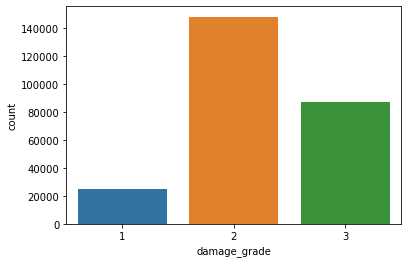

In [58]:
# Explore the target variable

print(train_labels['damage_grade'].value_counts())
sns.countplot(x='damage_grade', data=train_labels)

### Exploratory Analysis using DTale

In [59]:
import dtale

# Perform the exploration
dtale.show(train_features)

### Some feature transformations

In [60]:
# Transforming Label Transformations
label_encoder = LabelEncoder()

# Encode labels
train_features['land_surface_condition'] = label_encoder.fit_transform(train_features['land_surface_condition'])
train_features['foundation_type'] = label_encoder.fit_transform(train_features['foundation_type'])
train_features['roof_type'] = label_encoder.fit_transform(train_features['roof_type'])
train_features['ground_floor_type'] = label_encoder.fit_transform(train_features['ground_floor_type'])
train_features['other_floor_type'] = label_encoder.fit_transform(train_features['other_floor_type'])
train_features['position'] = label_encoder.fit_transform(train_features['position'])
train_features['plan_configuration'] = label_encoder.fit_transform(train_features['plan_configuration'])
train_features['legal_ownership_status'] = label_encoder.fit_transform(train_features['legal_ownership_status'])

## Perform Train-Test Split

In [61]:
X = train_features
y = train_labels['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)                                                                                                                                   

## Scaling the feature set

In [62]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Building the Model - Random Forest

In [63]:
# Imports
from sklearn.ensemble import RandomForestClassifier

In [64]:
# we will pass few hyperparameters in Grid for execution

param_grid = {'n_estimators': [50, 100, 200],
             'max_depth': [3, 4, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ["auto", "sqrt", "log2"],
             'bootstrap': [True, False]}

rfc_grid = GridSearchCV(RandomForestClassifier(random_state=101), param_grid=param_grid, cv=5, n_jobs=-2, verbose=1)

In [65]:
# Train the model
start = datetime.now()
rfc_grid.fit(X_train, y_train)
end = datetime.now()
print(f"The training of model completed in time - {end - start}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
The training of model completed in time - 0:18:26.707628


In [66]:
# Check the best params
rfc_grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 50}

In [67]:
predictionsRFC = rfc_grid.predict(X_test)

print("Confusion Matrix\n")
print(confusion_matrix(y_test,predictionsRFC))
print("\n")
print("Classification Report \n")
print(classification_report(y_test,predictionsRFC))
print("\n")
print("Accuracy Score \n")
print(accuracy_score(y_test, predictionsRFC))
print("\n")
print("F1 Score \n")
print(f1_score(y_test, predictionsRFC, average='micro'))

Confusion Matrix

[[  982  4039     1]
 [  503 29016   362]
 [   17 15840  1361]]


Classification Report 

              precision    recall  f1-score   support

           1       0.65      0.20      0.30      5022
           2       0.59      0.97      0.74     29881
           3       0.79      0.08      0.14     17218

    accuracy                           0.60     52121
   macro avg       0.68      0.42      0.39     52121
weighted avg       0.66      0.60      0.50     52121



Accuracy Score 

0.6016576811649815


F1 Score 

0.6016576811649815


## Building the Model - Gaussian Naive Bayes

In [68]:
from sklearn.naive_bayes import GaussianNB

gaussianNBClassifier = GaussianNB()
gaussianNBClassifier.fit(X_train, y_train)

GaussianNB()

In [69]:
predictionsGaussianNB = gaussianNBClassifier.predict(X_test)
print("Confusion Matrix - GaussianNB")
print(confusion_matrix(y_test, predictionsGaussianNB))
print("\n")
print("Accuracy Score - GaussianNB")
print(accuracy_score(y_test, predictionsGaussianNB))
print("\n")
print("Classification Report - GaussianNB")
print(classification_report(y_test, predictionsGaussianNB))
print("F1 Score \n")
print(f1_score(y_test, predictionsGaussianNB, average='micro'))

Confusion Matrix - GaussianNB
[[ 2430   997  1595]
 [ 3379  3671 22831]
 [  690  1019 15509]]


Accuracy Score - GaussianNB
0.4146121524913183


Classification Report - GaussianNB
              precision    recall  f1-score   support

           1       0.37      0.48      0.42      5022
           2       0.65      0.12      0.21     29881
           3       0.39      0.90      0.54     17218

    accuracy                           0.41     52121
   macro avg       0.47      0.50      0.39     52121
weighted avg       0.53      0.41      0.34     52121

F1 Score 

0.41461215249131833


## Building the Model - XGBoost Classifier

In [73]:

from xgboost import XGBClassifier

param_grid = {'n_estimators':[50, 100, 200, 300], 'max_depth' : [3, 4, 5], 'learning_rate':[0.001, 0.01, 0.1, 1, 10]}
xggrid = GridSearchCV(XGBClassifier(), param_grid, verbose=1, cv=5, n_jobs=-2)

In [74]:
# Train the model
start = datetime.now()
xggrid.fit(X_train, y_train)
end = datetime.now()
print(f"The training of model completed in time - {end - start}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/suvo/opt/miniconda3/envs/tensorflow-cpu/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:52:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The training of model completed in time - 1:07:05.492944


In [75]:
# Check the best params
xggrid.best_params_

{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 300}

In [76]:
xggrid_predictions = xggrid.predict(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, xggrid_predictions))
print("\n")
print("Accuracy Score")
print(accuracy_score(y_test, xggrid_predictions))
print("\n")
print("Classification Report")
print(classification_report(y_test, xggrid_predictions))
print("F1 Score \n")
print(f1_score(y_test, xggrid_predictions, average='micro'))

Confusion Matrix
[[ 2645  2277   100]
 [ 1260 24983  3638]
 [  138  5959 11121]]


Accuracy Score
0.7434431419197636


Classification Report
              precision    recall  f1-score   support

           1       0.65      0.53      0.58      5022
           2       0.75      0.84      0.79     29881
           3       0.75      0.65      0.69     17218

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

F1 Score 

0.7434431419197637


## Building the Model = Support Vector Machines

In [77]:
from sklearn.svm import SVC

# We will define a list of param values in a grid and run SV classifier across various combinations

#param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
svmgrid = GridSearchCV(SVC(), param_grid, verbose=100, cv=5, n_jobs=-2)

In [78]:
# Train the model
start = datetime.now()
svmgrid.fit(X_train, y_train)
end = datetime.now()
print(f"The training of model completed in time - {end - start}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 